---
## Initial Exploritory Data Analysis 
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# loading in training data
train_labels = pd.read_csv('../train_labels.csv')
train_labels.head()

/Users/alexarcher/Desktop/2244-HW5/notebook/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


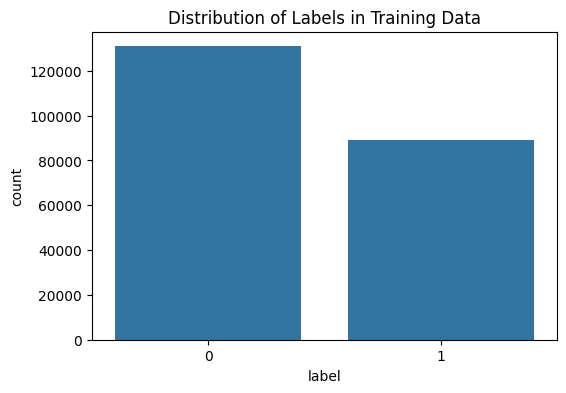

In [2]:
# plots out distribution of labels

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_labels)
plt.title('distribution of labels in training data')
plt.show()

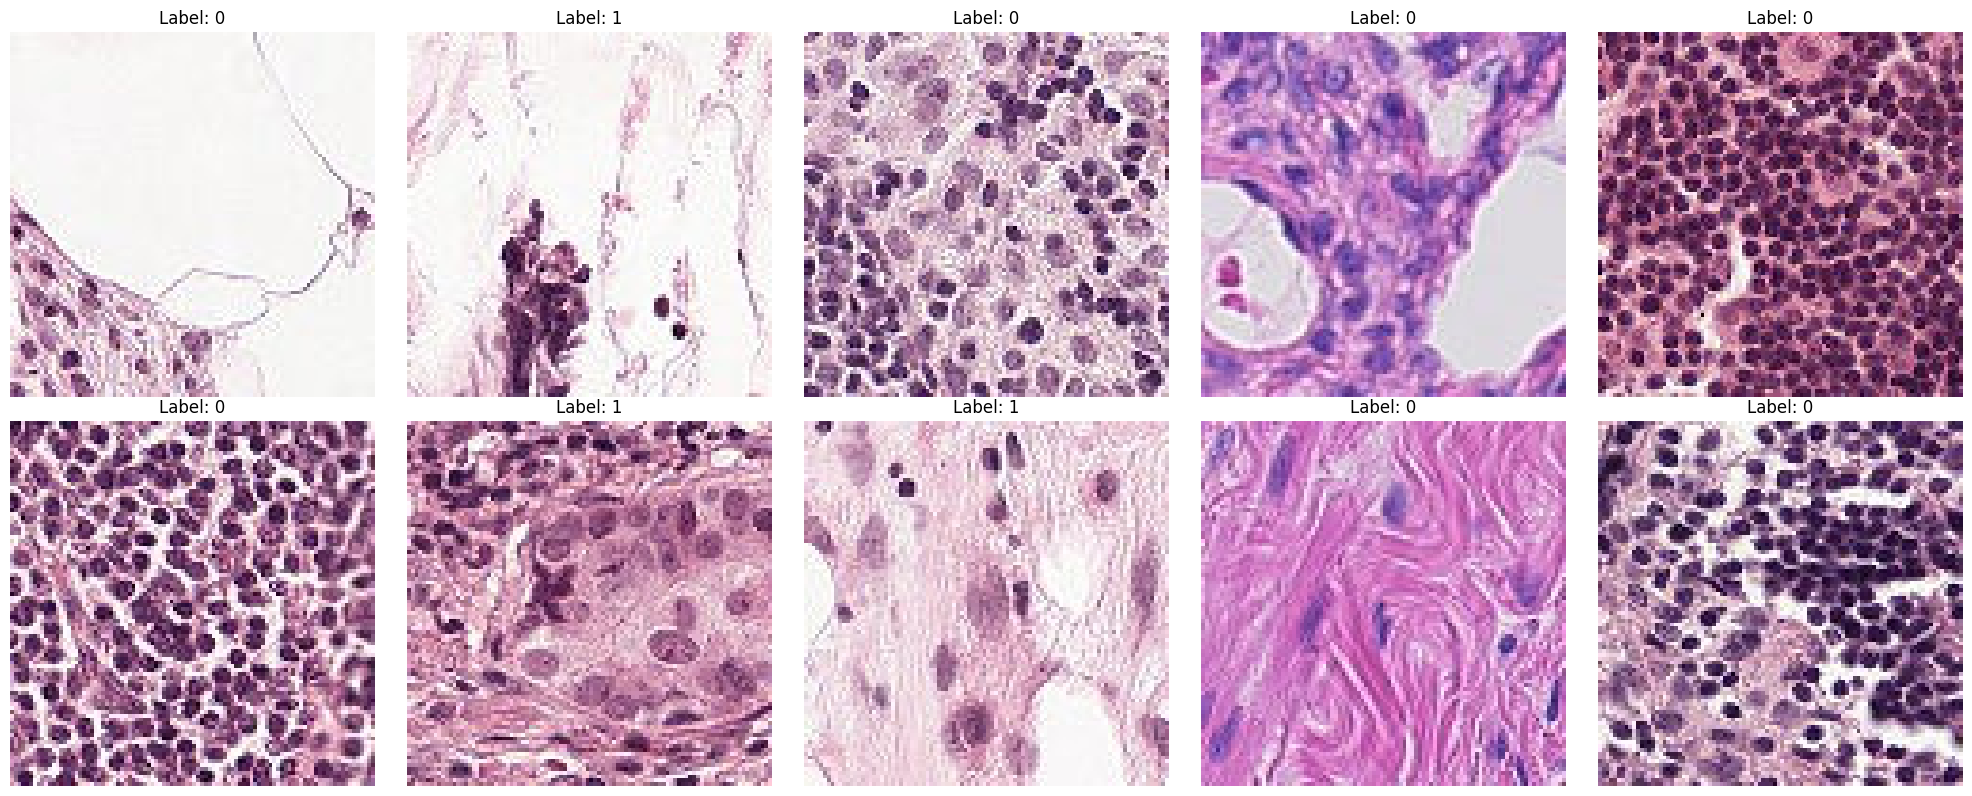

In [3]:
def load_image(img_id, img_folder='../train'):

    img_path = os.path.join(img_folder, f'{img_id}.tif')

    return Image.open(img_path)

# shows sample images

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, ax in enumerate(axes.flat):

    img_id = train_labels.loc[i, 'id']
    img = load_image(img_id)

    label =train_labels.loc[i,  'label']
    ax.imshow(img)
    ax.set_title(f'Label: {label}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [4]:
# finds missing values
print(train_labels.isnull().sum())

#  no duplicates
print(train_labels.duplicated().sum())

# dimensions of the images
sample_image = load_image(train_labels.loc[0, 'id'])
print(f'Image size: {sample_image.size}')

id       0
label    0
dtype: int64
0
Image size: (96, 96)


In [5]:
# load in training data
train_labels = pd.read_csv('../train_labels.csv')

# image loading function
def load_image(img_id, img_folder='../train'):

    img_path = os.path.join(img_folder, f'{img_id}.tif')
    return np.array(Image.open(img_path))

# loads images/labels
X = np.array([load_image(img_id) for img_id in tqdm(train_labels['id'])])
y = train_labels['label'].values

# normalizing pixels
X = X / 255.0

100%|██████████| 220025/220025 [02:01<00:00, 1815.19it/s]


In [6]:
# splits data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [7]:
datagen = ImageDataGenerator( rotation_range = 20, width_shift_rang =0.2, height_shift_range = 0.2, horizontal_flip=True, fill_mode ='nearest')

# needed to use small batch due to python crashing
small_batch = X_train[:35000]
datagen.fit(small_batch)

In [8]:
# data generator function
def data_generator(X, y, batch_size, datagen):
    data_len = len(X)
    indices = np.arange(data_len)

    while True:
        np.random.shuffle(indices)

        for start in range(0, data_len, batch_size):

            end = min(start + batch_size, data_len)

            batch_indices = indices[start:end]

            batch_X = X[batch_indices]
            batch_y = y[batch_indices]

            augmented_X = np.array([datagen.random_transform(img) for img in batch_X])

            yield augmented_X, batch_y

# data augmentation
datagen = ImageDataGenerator(rotation_range = 20, width_shift_range =0.2, height_shift_range = 0.2, horizontal_flip=True, fill_mode='nearest')

# generators for training/validation data
train_generator = data_generator(X_train, y_train, 32, datagen)
val_generator = data_generator(X_val, y_val, 32, datagen)

In [9]:
# the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/alexarcher/Desktop/2244-HW5/notebook/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# calculates steps per epoch
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

# training the model using the generator
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, validation_data = val_generator, validation_steps = validation_steps, epochs = 5, verbose= 1)

Epoch 1/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 573s 104ms/step - accuracy: 0.7861 - loss: 0.4663 - val_accuracy: 0.8475 - val_loss: 0.3516
Epoch 2/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 571s 104ms/step - accuracy: 0.8441 - loss: 0.3612 - val_accuracy: 0.8681 - val_loss: 0.3097
Epoch 3/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 570s 104ms/step - accuracy: 0.8629 - loss: 0.3256 - val_accuracy: 0.8765 - val_loss: 0.3018
Epoch 4/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 563s 102ms/step - accuracy: 0.8711 - loss: 0.3096 - val_accuracy: 0.8837 - val_loss: 0.2853
Epoch 5/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 570s 104ms/step - accuracy: 0.8771 - loss: 0.2972 - val_accuracy: 0.8792 - val_loss: 0.2955


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step
Validation prediction time: 0.71 minutes
Validation ROC AUC: 0.4992568249840997


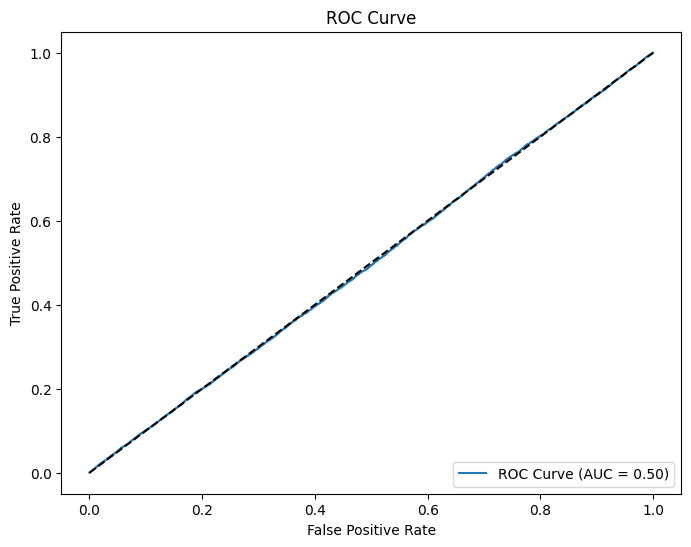

In [12]:
import time

validation_steps = len(X_val) // 32

start_time = time.time()
val_predictions = model.predict(val_generator, steps=validation_steps)
end_time = time.time()

print(f"validation prediction time: {(end_time - start_time) / 60:.2f} minutes")

val_predictions = val_predictions.flatten()

roc_auc = roc_auc_score(y_val[:len(val_predictions)], val_predictions)
print(f"validation ROC AUC: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_val[:len(val_predictions)], val_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

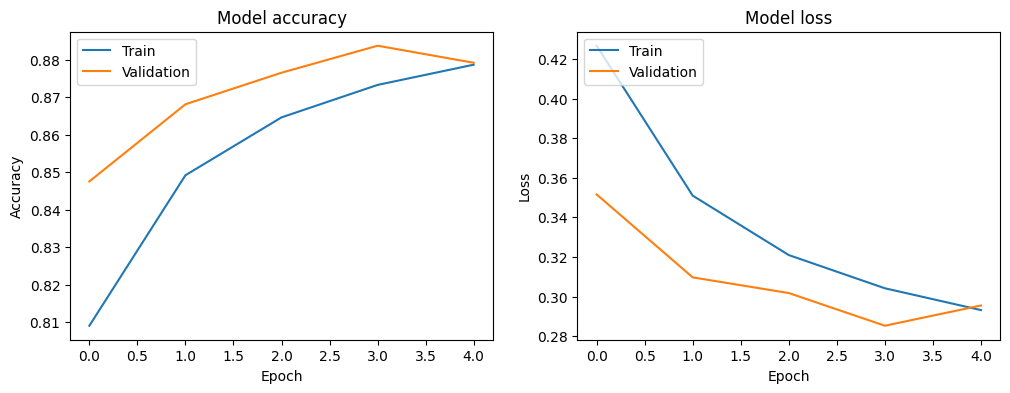

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()